📝 Hello, this is the Week 6 in-lecture notebook to complete during class.

In Lecture 7 we will finish our discussion of fully connected nueral networks 🧠 and begin discussing convolutional neural networks.

In [6]:
%pip install torch

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

For your final homework (the one assigned last week) you are using PyTorch to do a linear regression assignment, similar to the assignments you had in previous homeworks. This notebook is here to help build up some of the pieces you will use going forward when making neural networks.

Let's imagine we are building a classifier for images. These images will be given to us as grayscale 3x3 images. (These would obviously be VERY simple images, this is just for tutorial reasons.) These images can either be bears 🐻, dogs 🐕, cats 🐈, or fish 🐟.

First a few questions to think about:
1. How many inputs does our neural network have?
2. How should we change our input to make it easier to feed to the neural network?
3. How many outputs does our neural network have?
4. If our neural network does not use hidden layers, what would the dimensions of the array that represent our transformation from input to output be?
5. What does this say about the dimensions of the arrays that make up all of our stages?

📰 Task 1: Convert the 3x3 tensor into a 1x9 tensor which will be a better input for our neural network. First do this with the individual tensor (in1), then try to do it with the list of tensors (our "training data"). Then append the flattened in1 to the flattened training data (making it the 100th piece of data).

Hint: consider using one of the following:
* torch.flatten
* torch.reshape
* torch.cat

In [8]:
#3x3 tensor

np.random.seed(0)
in1_numpy = np.random.randint(256, size=(3,3))
in1 = torch.tensor(in1_numpy, dtype=torch.float)

in99_numpy = np.random.randint(256, size=(99, 3, 3))
in99 = torch.tensor(in99_numpy, dtype=torch.float)

picture_labels_numpy = np.random.randint(4, size=(100))
picture_labels = torch.tensor(picture_labels_numpy, dtype=torch.float)

########################
## YOUR CODE STARTS HERE
########################

# Task 1: Flatten in1 to be a (1x9) tensor, then flatten training_data to a (99x9) tensor, then concatenate both into a (100x9) tensor
in1 = in1.reshape(1,9)
in99 = in99.reshape(99,9)
print(in1.shape)
print(in99.shape)
final = torch.cat((in1, in99))
print(final.shape)

########################
## YOUR CODE ENDS HERE
########################

torch.Size([1, 9])
torch.Size([99, 9])
torch.Size([100, 9])


🚆 Task 2: Make a simple neural network with one hidden layer for your data. The hidden layer should have 5 neurons on it. You can store your weights in two matrices, and initialize them to 1s or random numbers. Convert your input data to the hidden layer and then that to your output data by multiplying your input by the weight matrices.

Things to consider:

1. Why do we use matrices to store our weights?
Ans: Matrix multiplication efficiently transforms input data through different layers of a neural network. Matrices allow us to handle multiple inputs and neurons simultaneously, making computations easier, structured and scalable for larger networks. 

2. What will the dimensions of our matrices be?
Assuming the input data has $n$ features, and our network has a hidden layer with 5 neurons and an output layer with $m$ outputs, the weight matrices will have the following dimensions:
- W1: nx5
- W2: 5xm

Assuming that the forward pass is $xW$

In [19]:
########################
## YOUR CODE STARTS HERE
########################

# Define layer sizes
input_size = final.shape[1]
hidden_size = 5
output_size = 4

#Initialize weights randomly
W1 = torch.randn(input_size, hidden_size)
W2 = torch.randn(hidden_size, output_size)

#Forward pass
hidden_layer = torch.matmul(final, W1)
output_layer = torch.matmul(hidden_layer, W2)

print("Hidden layer shape:", hidden_layer.shape)
print("Final output shape:", output_layer.shape)

########################
## YOUR CODE ENDS HERE
########################

Hidden layer shape: torch.Size([100, 5])
Final output shape: torch.Size([100, 4])


Your output should now be a 100 x 4 matrix of numbers, each of which are unbounded. We would prefer to have each row's values sum to 1, so that the four numbers represent the probability that the image is a bear, dog, cat, or fish, respectively.

🧮 Task 3: Use the softmax function to convert our outputs into probabilities

Hint: Look up the torch.nn.functional.log_softmax function! The dim parameter allows us to specify which dimension we want to apply our function along.

For example, if we set dim=0, softmax will be applied along the column and each column will sum to 1. Conversely, if we set dim=1, softmax will be applied along the row and each row will sum to 1. Think about which one we want and set dim accordingly.

In [23]:
########################
## YOUR CODE STARTS HERE
########################

import torch.nn.functional as F
log_probabilities = F.log_softmax(output_layer, dim=1)
########################
## YOUR CODE ENDS HERE
########################

Now we come across a common, but ultimately easy-to-solve problem in neural networks: how we should represent the output. Currently our output is a 100x4 matrix, but picture_labels (the correct output) is a 100x1 matrix.

We can convert each row in picture_labels to three zeros and a single one value (1x4) to match our netural network's output. This is called a one-hot encoding. As of now, our actual picture label is only a single value for each image (thus a tensor of 100 values for the 100 images). This is called an integer encoding. Let's convert picture_labels to a one hot encoding so that we can compare it with our neural network's output.

Example of conversion from integer to one-hot encoding: \
[0] -> [1 0 0 0] \
[1] -> [0 1 0 0] \
[2] -> [0 0 1 0] \
[3] -> [0 0 0 1]

📭 Task 4: Use a pytorch function (or make your own) to convert the picture_labels matrix to one hot encoding. Then compute the log-loss of your estimated output and the actual output.

Hint: the following may be helpful:
*   torch.nn.functional.one_hot
*   torch.nn.nll_loss

In [ ]:
########################
## YOUR CODE STARTS HERE
########################
picture_labels =picture_labels.to(torch.int64)
one_hot_labels = F.one_hot(picture_labels, num_classes=4)

# Converting to one hot encoding is NOT compatible with the nll_loss function. The torch implementation of this function specifcially requires the target to be a tensor of class indices (not one hot encoded vectors)

log_loss = F.nll_loss(log_probabilities, picture_labels)
print(log_loss)
########################
## YOUR CODE ENDS HERE
########################

tensor(748.3094)


Now that you have seen how a fully connected neural network works we are going to convert everything into PyTorch. When building actual neural networks in PyTorch we are going to use a class to represent the network. We will train an instance of this class for our model.

🔃 Task 5: Create a class that will represent your neural network structure. You may add any layers you want to this, but keep in mind that between linear layers you are going to want a ReLU. Create the \_\_init__() and forward() methods for the class.

Hint: the following may be helpful:
* https://pytorch.org/docs/stable/generated/torch.nn.Module.html

In [44]:
########################
## YOUR CODE STARTS HERE
########################

class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(in_features=9, out_features=64)
    self.fc2 = nn.Linear(in_features=64, out_features=32)
    self.fc3 = nn.Linear(in_features=32, out_features=4)

    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.fc3(x)
    return x

model = NeuralNetwork()

########################
## YOUR CODE ENDS HERE
########################

⛳ Task 6: Use the following training loop to train your model. Don't worry about splitting this model into training and testing data, these are just random values so they should not actually train to anything relevant.

In [45]:
########################
## YOUR CODE STARTS HERE
########################

num_epochs = 10
learning_rate = 0.001
momentum = 1
num_epochs_to_print = 1

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

for i in range(num_epochs):

  optimizer.zero_grad()

  outputs = model(final)
  loss = criterion(outputs, one_hot_labels.float())
  loss.backward()
  optimizer.step()

  if i % num_epochs_to_print == 0:
    print(loss.item())

########################
## YOUR CODE ENDS HERE
########################

43.881134033203125
16.60980987548828
12.779125213623047
14.151317596435547
9.221146583557129
5.8320794105529785
5.058023452758789
2.6289825439453125
1.6502537727355957
1.6072630882263184


⏭ Task 7: (Optional) Add some convolutional neural network layers that we learned in class today to your model and try retraining. Think about the dimensions and what dimensions should be correct (consider printing shapes of the data at various stages).

[[1 1 1]
 [1 0 0]
 [1 0 0]]
[[3. 1. 1. 0. 0. 0. 1.]
 [4. 1. 1. 1. 0. 0. 1.]
 [4. 1. 1. 1. 1. 0. 1.]
 [3. 1. 1. 1. 1. 1. 1.]
 [3. 0. 1. 1. 1. 1. 2.]
 [3. 0. 0. 1. 1. 1. 2.]
 [3. 0. 0. 0. 1. 1. 2.]]


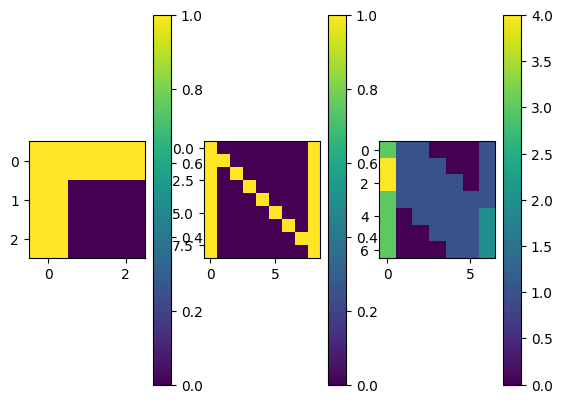

In [47]:
import matplotlib.pyplot as plt
import numpy as np

def conv(kern, img):
  out = np.zeros((7, 7))
  for i in range(7):
    for j in range(7):
      out[i][j] = sum(sum(img[i:i+3, j:j+3] * kern))
  return out

kernel_temp = [[1,1,1],[1,0,0],[1,0,0]]
kernel = np.array(kernel_temp)

imageX = np.zeros((9, 9))
imageN = np.zeros((9, 9))
imageZ = np.zeros((9, 9))
imageO = np.zeros((9, 9))
for i in range(9):
  for j in range(9):
    if i == j or i == 8 - j:
      imageX[i][j] = 1.0
    if i == j or j == 0 or j == 8:
      imageN[i][j] = 1.0
    if i == 8 - j or i == 0 or i == 8:
      imageZ[i][j] = 1.0
    if i == 1 or i == 7 or j == 1 or j == 7:
      if not (i == 0 or j == 0 or i == 8 or j == 8):
        imageO[i][j] = 1.0

image = imageN

out = conv(kernel, image)

plt.subplot(1, 3, 1)
plt.imshow(kernel)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(image)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(out)
plt.colorbar()

print(kernel)
print(out)

## Report

Notes:
- Instructions in this notebook seem to be misguiding. Converting to one hot encoding is NOT compatible with the nll_loss function. The torch implementation of this function specifcially requires the target to be a tensor of class indices (not one hot encoded vectors).

Did you know that octopuses have three hearts? Two hearts pump blood to the gills, while the third pumps it to the rest of the body. And when an octopus swims, the heart that delivers blood to the body actually stops beating, which is one reason why they prefer crawling rather than swimming—it's less tiring for them!